In [1]:
# Program for idnentifying defects in steel surfaces

In [1]:
import os
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split,TensorDataset, DataLoader
import torch.nn as nn
import torch
import torchvision.models as models
from sklearn.metrics import ConfusionMatrixDisplay
from torchinfo import summary



In [3]:
from detector.data_reader import DataReader
from detector.model_manual_AlexNET import AlexNET
from detector.model_manual_inception import inception
from detector.model_manual_ResNET import manual_resnet
from detector.model_ResNET import resnet
from detector.model_small_conv import small_conv
from detector.model_mobileNetV3 import mobilenet
from detector.write_wrong_detections import write_wrong_detections

In [3]:
# Check if Cuda is available
print("Cuda available: ", torch.cuda.is_available())
print("Cuda device:", torch.cuda.get_device_name(0))

Cuda available:  True
Cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [5]:
# Path to the Data
curr_path=os.path.dirname(os.getcwd())
data_subdir_path="\\Dataset-trafo\\"
data_path=curr_path+data_subdir_path
test=torchvision.io.read_image(data_path+"good\\"+"10000.png")
print(test.size())
print(data_path)

torch.Size([3, 645, 229])
c:\Users\Admin\Desktop\Detector\Steel-defect-detector\Dataset-trafo\


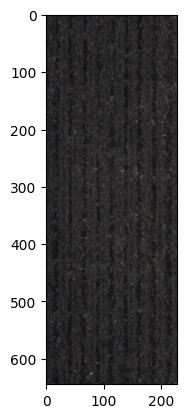

In [6]:
# Show test image
plt.imshow(test.permute(1,2,0))

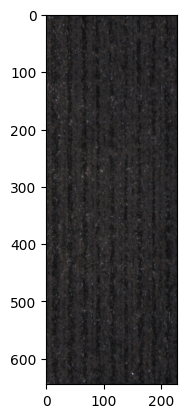

In [7]:
#Test of flip function on test image
test_flipped=torchvision.transforms.functional.hflip(test)
plt.imshow(test_flipped.permute(1,2,0))

X_batch_size: torch.Size([1836, 3, 633, 228])


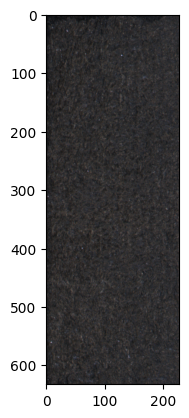

In [8]:
# Creating x_batch, y_batch from images in data_path
x_batch,y_batch,df1=DataReader(data_path=data_path) # get x_batch, y_batch
plt.imshow(x_batch[100].permute(1,2,0)) # test if all worked out ok
print("X_batch_size:",x_batch.size())


(array([654.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 264.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

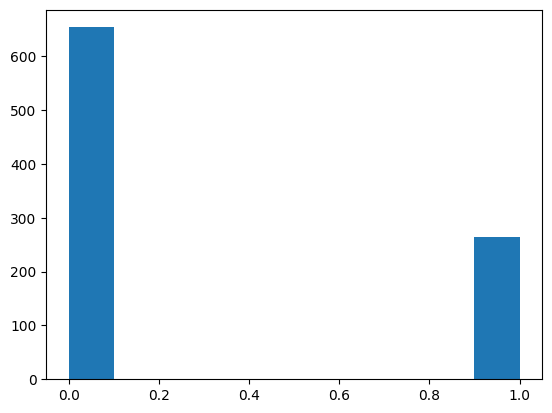

In [9]:
# Plotting histogram of labels to get insides in the distribution
plt.hist(df1["label"])

In [10]:
# Seperation in train and test set
train_set_size=0.9
ds=TensorDataset(x_batch,y_batch)
len_train_ds=int(len(x_batch)*train_set_size)
len_test_ds=len(x_batch)-len_train_ds
train_ds, test_ds=random_split(ds,[len_train_ds,len_test_ds]) # random split the Dataset in train and test set



In [11]:
# Dataloader for train set
batch_size=24   # max. possible size on current GPU for models (see later)
torch.manual_seed(1)
train_dl = DataLoader(train_ds,batch_size, shuffle=True)


In [12]:
# Model selection by removing "#"; best perfomance: models.resnet.ResNet with 30-40 Epochs

In [13]:
model=models.resnet.ResNet(models.resnet.BasicBlock, [2, 2, 2, 2],num_classes=2)
#model=models.mobilenet.mobilenet_v3_small(num_classes=2)
#model=AlexNET()
#model=small_conv()
#model=inception()
#model=resnet()
summary(model)


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [14]:
# Training Loop (here without learning rate decay)
model=model.cuda()
loss_fn = nn.CrossEntropyLoss()
torch.manual_seed(1)
accuray_array=[]
num_epochs = 5

for epoch in range(num_epochs):
    optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001) # standard lr=0.001
    accuracy_hist_train=0
    for x_batch, y_batch in train_dl:
        x_batch=x_batch.cuda()
        y_batch=y_batch.cuda()
        pred=model(x_batch)
        loss=loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train+=is_correct.sum()
        torch.cuda.empty_cache()
    accuracy_hist_train/=len(train_dl.dataset)
    print(f'Epoch {epoch} Accuracy ' f'{accuracy_hist_train:.4f}')
    torch.cuda.empty_cache()

Epoch 0 Accuracy 0.8832
Epoch 1 Accuracy 0.9122
Epoch 2 Accuracy 0.9219
Epoch 3 Accuracy 0.9340
Epoch 4 Accuracy 0.9358


In [15]:
# Accuracy on test set
x_test,y_test=test_ds[:]
with torch.no_grad():
    model=model.cpu() # putting Model on CPU, because it can handle more memory: no need for Dataloader -> simplification for test-set
    pred=model(x_test)
is_correct = (torch.argmax(pred, dim=1) == y_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9511


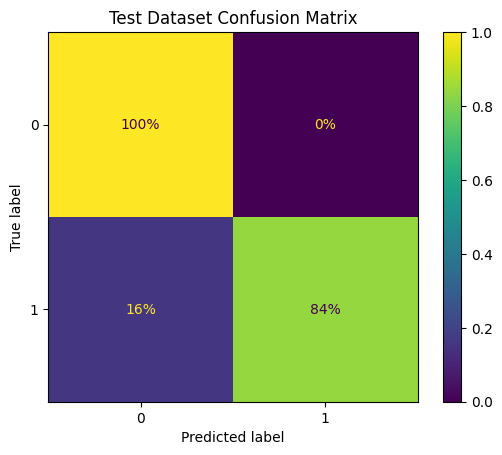

In [16]:
# Show Confusion Matrix on test set
pred_single_values=torch.argmax(pred,dim=1)
pred_numpy=pred_single_values.detach().numpy()
y_test.numpy()
ConfusionMatrixDisplay.from_predictions(y_test,pred_numpy, normalize="true", values_format=".0%")
plt.title('Test Dataset Confusion Matrix')
plt.show()

In [20]:
# Writing wrong detections to folders for further inspection
write_wrong_detections(data_path=data_path,x_test=x_test,y_test=y_test, is_correct=is_correct)

In [31]:
# Save model
if not ( os. path. isdir(curr_path+"\\model_parameters")):
    os.mkdir(path=curr_path+"\\model_parameters")
torch.save(model, curr_path+"\\model_parameters\\model.md")